# Notebook Purpose

# Import Dependencies

Dependencies will also compile special loss functions (CUDA implemented Earth Mover's Distance) which is in the `emd/structured_losses` directory.

In [5]:
import numpy as np
from pointcloud_helpers import *

import keras
from keras.losses import MSE
from keras.layers import Lambda, Input, Dense, Conv1D, Conv2D, MaxPooling1D, BatchNormalization, MaxPooling2D, Flatten, Reshape, UpSampling2D, Dropout
from keras.models import Model, Sequential,load_model
from keras import callbacks
from keras import backend as K
import pandas as pd
config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

K.clear_session()

In [7]:
semantic_net = load_model("../data/chair_net_250.h5", custom_objects={ 'emd': emd})
semantic_df = pd.read_csv("../data/semantic-data.csv")


Recognition versus refcall on galleries, and the wa search makes people need to know what they want

Internal baseline for how useful SWOW is, measuring the contribution
these are the worrds that work -- 
metric for showing this is better than random /average

look at metaphoria -- is it apt and is it diverse


Surfacing the adjectives that described it, see more like this --similarity functions

Beat random?

metashapes revisited? 

In [18]:
semantic_df

Unnamed: 0                                   name  \
0              0       935093c683edbf2087946594df4e196c   
1              1        82979f3a00ca7b5b0003dd98e70da8e   
2              2       82ac145a471e406f35836c728d324152   
3              3       eeafc14e4e0db2ca3b481215325f1515   
4              4       3919e93cc1f3bf5bd7f7a4c4609b0913   
5              5       b6985891e45b998e7181375a1be1d1c9   
6              6       fee248777c9c4807f8bc1f8036e08e44   
7              7       7d7b3b8a1734154b3b8d5c0ebdd194c8   
8              8       545e984b290a7398e8b2b8dc0c816caf   
9              9       60a8c55e653a107ca192483aa282f8e5   
10            10       a374415a1ccc05aa283b00891f680579   
11            11       6895e7aa3c739623927045b355fe1fe3   
12            12       7d7b3b8a1734154b3b8d5c0ebdd194c8   
13            13       c8ccac20f5cc12528ebcc1a99d4058f2   
14            14       ba2f3a0d2e90025bb3234e0da44b11e4   
15            15       e14e8241e0bb563f64810cc21086da42   
16            16       76389d102e3fb729f51f77a6d7299806   
17            17       4c30d612b8663402492d9da2668ec34c   
18            18        646ce5490817ceef4b6538438a0b930   
19            19       f497cbcc4895d5386b684500e5db87c2   
20            20       86b6e539e72be6d46fa0ab61d9f9d96d   
21            21        cc70b9c8d4faf79e5a468146abbb198   
22            22       4e9475fea6f3ca32c4cb3d6800567627   
23            23       d2b334ad08ac9857c3cf9ae716575390   
24            24       b9ac31cc001a0ab72a64ba172c1ba615   
25            25       23e726da58f115f69b9f2eb77f5e247e   
26            26       3230b6c7f396afff19fb4103277a6b93   
27            27       239a5029476b8a2adb6f46583a3903bd   
28            28       898dc475a4f36d0d35836c728d324152   
29            29       5c0d4cf28a71ad7296db593b49da23e5   
...          ...                                    ...   
1313        1313       92cae2e67b788eaa9dcc460592c0e125   
1314        1314       2aa2d2bb646fdc511b7ca0421af5a45e   
1315        1315       5bd08666f29e946c988a5637d6d8f36a   
1316        1316       8c76b1db0a08653ffebad4f49b26ec52   
1317        1317       b94002e3a92ca65efdcf3d27ddf91f4c   
1318        1318       cc1b4eb1a9164e04f06885bd08de3f64   
1319        1319       be4c88a130e622a21961e650f3cfa396   
1320        1320       341e18eafb46f892a6fee8e2140acec9   
1321        1321       1d6faeb6d77d1f2cf95cd8df6bebbc3a   
1322        1322       f06d2963ad258feaf5adaa9eef900be3   
1323        1323  udf068a6b-e65b-430b-bc17-611b062e2e34   
1324        1324       8979c1aaa6675009bf80985a99195eb8   
1325        1325        d4e0707b680e61e0593ebeeedbff73b   
1326        1326       55c9891ac274e076492d9da2668ec34c   
1327        1327        cfe139c0e8b8cfdae342bce0d924820   
1328        1328       8ac35c25faa261ef4f3443b22038d340   
1329        1329       aa05a0db9ab12c5e3e7d886a315f2350   
1330        1330       57263b7b778ac3a87c076cdc1de5871a   
1331        1331       a6d282a360621055614d73f24792753f   
1332        1332       2948af0b6a12f1c7ad484915511ccff6   
1333        1333       a6a7b00de9ccce0816a5604496f9ff11   
1334        1334       c7739fa5e32a7218a5f9d52c12457194   
1335        1335       75b9ddc5017a5eb137f8f3a1ea8633a9   
1336        1336       681203ebfa280f5696d5b0735c6b5f03   
1337        1337       8e1d232ce609392ebd8eb8ad250e5135   
1338        1338       484a7d924c952e51af7c7ad2549a1b15   
1339        1339        7f73cc6c1c9121a9b9f2eb77f5e247e   
1340        1340       75b1bcb68c8344261a648655355dc699   
1341        1341       5bfee410a492af4f65ba78ad9601cf1b   
1342        1342       78ba9e32a9a5c276f69d13812ce67f33   

                                              shapeglot  \
0                                chair go kitchen table   
1                                             rectangle   
2                                           curved seat   
3                                       tombstone shape   
4                                          office ch

In [8]:
decoder = semantic_net.layers[-1].layers[-1]
encoder = semantic_net.layers[-1].layers[-2]

# Check model outputs qualitatively

Note that there are 6 dimensions that can be altered. They map to the semantic parameters in this order:  torso_length, neck_length, neck_rotation, leg_length, tail_length, tail_rotation. As all parameters were normalized prior to training, any value between 0-1 is valid.

In [9]:
chair_ptclouds = np.load("../data/chair_pointclouds.npz")["arr_0"]

from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from flask import Flask, send_file, request, jsonify, g
from werkzeug.exceptions import BadRequest
from werkzeug.utils import secure_filename

app = Flask(__name__)
#handles web requests from unity
@app.route('/', methods=["POST"])
def evaluate():
    values = request.form["values"].split('|')
    
    #split the parameter values into something
    values = np.array([float(val) for val in values])
    random_decoded = decoder.predict(values.reshape(1,1,1,23)).reshape(6144)
    
    xyz_string = ",".join([str(pt) for pt in random_decoded.tolist()])

    #return 12 nearest neighbors
    return jsonify(xyz_string)

def run():
    app.run(host='0.0.0.0',port=5000, threaded=False)


In [10]:
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from flask import Flask, send_file, request, jsonify, g
from werkzeug.exceptions import BadRequest
from werkzeug.utils import secure_filename


In [11]:

def run():
    app.run(host='0.0.0.0',port=5000, threaded=False)


In [12]:
import random
import pandas as pd

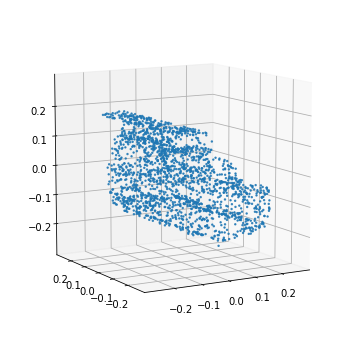

In [13]:
plot_ptcloud(chair_ptclouds[5])

In [24]:
def find_match(dataframe, search_query, num_matches, dataframe_col="search_query"):
    hits =dataframe["bag_of_words"].str.find(search_query)
    
    print(hits)
    hits = dataframe["name"].where(hits > -1).dropna().index
    set_of_hits = [int(hits.values[i]) for i in range(num_matches) ] 
    
    
    print(set_of_hits)
    return set_of_hits

In [25]:
app = Flask(__name__)
encoded_base = None
# pcd = o3d.geometry.PointCloud()
#handles web requests from unity
@app.route('/', methods=["POST"])
def evaluate():
    global encoded_base
    
    search_query = request.form["search_query"].encode('utf8')
    search_hits = find_match(semantic_df, search_query, 4)
    
    print(request.form["dimension_to_edit"])
    
    
    
    encoder = semantic_net.layers[-1].layers[-2]
    decoder = semantic_net.layers[-1].layers[-1]
    
    pointcloud_hits = [encoder.predict(chair_ptclouds[i].reshape(1,2048,1,3)) for i in search_hits]
    encoded_base = pointcloud_hits[0]
    pointcloud_hits = np.array([decoder.predict(pointcloud) for pointcloud in pointcloud_hits]).flatten()
    
    xyz_string = ",".join([str(pt) for pt in pointcloud_hits])

    
    return jsonify(xyz_string)

In [26]:
@app.route('/edit', methods=["POST"])
def edit_base():
#     global encoded_base
    edit_dimension = int(request.form["dimension_to_edit"])
    edit_magnitude = float(request.form["edit_magnitude"])
    
    encoded_base[0,0,0][edit_dimension] += edit_magnitude
    pointcloud = np.array(decoder.predict(encoded_base) ).flatten()
    xyz_string = ",".join([str(pt) for pt in pointcloud])

    return jsonify(xyz_string)

In [ ]:
run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
172.17.0.1 - - [04/Jun/2021 19:33:38] "POST / HTTP/1.1" 200 -


0         -1
1         -1
2         -1
3         -1
4         -1
5         -1
6         -1
7         -1
8         -1
9         -1
10        -1
11       765
12        -1
13        -1
14        -1
15        -1
16        -1
17      1560
18        -1
19        -1
20        -1
21      1502
22      1502
23        -1
24        -1
25        -1
26        -1
27        -1
28        -1
29        -1
        ... 
1313      -1
1314     765
1315      -1
1316     765
1317      -1
1318      -1
1319      -1
1320      -1
1321     765
1322      -1
1323      -1
1324      -1
1325      -1
1326      -1
1327      -1
1328      -1
1329     765
1330      -1
1331      -1
1332      -1
1333      -1
1334      -1
1335    2000
1336      -1
1337      -1
1338      -1
1339      -1
1340    2371
1341      -1
1342      -1
Name: bag_of_words, Length: 1343, dtype: int64
[11, 17, 21, 22]
-1


172.17.0.1 - - [04/Jun/2021 19:51:21] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:21] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:21] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:21] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:21] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:21] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:21] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:22] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:22] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:22] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:22] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:22] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:22] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:22] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:22] "POST /edit HTTP/1.1" 200 -
172.17.0.1

172.17.0.1 - - [04/Jun/2021 19:51:23] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:23] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:23] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:23] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:23] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:23] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:23] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:23] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:23] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:23] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:23] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:23] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:23] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:23] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:23] "POST /edit HTTP/1.1" 200 -
172.17.0.1

172.17.0.1 - - [04/Jun/2021 19:51:24] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:24] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:24] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:24] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:24] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:24] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:24] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:24] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:24] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:24] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:24] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:24] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:24] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:24] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:24] "POST /edit HTTP/1.1" 200 -
172.17.0.1

172.17.0.1 - - [04/Jun/2021 19:51:25] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:25] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:25] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:25] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:25] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:25] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:25] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:25] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:25] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:25] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:25] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:25] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:25] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:25] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:25] "POST /edit HTTP/1.1" 200 -
172.17.0.1

172.17.0.1 - - [04/Jun/2021 19:51:26] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:26] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:26] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:26] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:26] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:26] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:26] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:26] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:26] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:26] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:26] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:26] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:26] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:26] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:26] "POST /edit HTTP/1.1" 200 -
172.17.0.1

172.17.0.1 - - [04/Jun/2021 19:51:27] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:27] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:27] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:27] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:28] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:28] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:28] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:28] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:28] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:28] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:28] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:28] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:28] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:28] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:28] "POST /edit HTTP/1.1" 200 -
172.17.0.1

172.17.0.1 - - [04/Jun/2021 19:51:29] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:29] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:29] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:29] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:29] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:29] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:29] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:29] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:29] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:29] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:29] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:29] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:29] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:29] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:29] "POST /edit HTTP/1.1" 200 -
172.17.0.1

172.17.0.1 - - [04/Jun/2021 19:51:30] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:30] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:30] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:30] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:30] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:30] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:30] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:30] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:30] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:30] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:30] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:30] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:30] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:30] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:30] "POST /edit HTTP/1.1" 200 -
172.17.0.1

172.17.0.1 - - [04/Jun/2021 19:51:31] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:31] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:31] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:31] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:31] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:31] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:31] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:31] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:31] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:31] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:31] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:31] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:31] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:31] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:31] "POST /edit HTTP/1.1" 200 -
172.17.0.1

172.17.0.1 - - [04/Jun/2021 19:51:32] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:32] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:32] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:32] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:32] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:32] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:32] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:32] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:32] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:32] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:32] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:32] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:32] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:32] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:32] "POST /edit HTTP/1.1" 200 -
172.17.0.1

172.17.0.1 - - [04/Jun/2021 19:51:33] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:33] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:33] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:33] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:33] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:33] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:33] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:33] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:33] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:33] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:33] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:33] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:33] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:33] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:33] "POST /edit HTTP/1.1" 200 -
172.17.0.1

172.17.0.1 - - [04/Jun/2021 19:51:34] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:35] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:35] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:35] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:35] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:35] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:35] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:35] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:35] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:35] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:35] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:35] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:35] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:35] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:35] "POST /edit HTTP/1.1" 200 -
172.17.0.1

172.17.0.1 - - [04/Jun/2021 19:51:36] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:36] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:36] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:36] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:36] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:36] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:36] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:36] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:36] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:36] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:36] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:36] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:36] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:36] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:36] "POST /edit HTTP/1.1" 200 -
172.17.0.1

172.17.0.1 - - [04/Jun/2021 19:51:37] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:37] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:37] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:38] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:38] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:38] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:38] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:38] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:38] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:38] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:38] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:39] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:39] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:39] "POST /edit HTTP/1.1" 200 -
172.17.0.1 - - [04/Jun/2021 19:51:39] "POST /edit HTTP/1.1" 200 -
172.17.0.1

In [62]:
encoded_base[0,0,0].shape

(128,)